## Machine Learning - Models

In [110]:
# import libs

import itertools
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd
import sklearn
import time
import timeit

from catboost import Pool, CatBoostClassifier
from pylmnn import LargeMarginNearestNeighbor as LMNN
from scipy.spatial.distance import euclidean, mahalanobis, minkowski, chebyshev
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import metrics

%matplotlib inline

# import warnings
# warnings.filterwarnings('always') # "error", "ignore", "always", "default", "module" or "once"

**Load data (csv file + features)**

In [2]:
path='features.csv'
df=pd.read_csv(path, sep=",")
df.head(10)

,time,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
0,2008-03-28 14:54:40,39.894178,116.318200,-777.0,6,10,34.0,253.375124,7.452210,0.008984,...,7004.449301,28.591177,0.037348,0.000050,180.584289,0.387508,0.0,0.0,0.110478,0.0
1,2008-03-28 14:55:14,39.894505,116.321132,-777.0,6,10,59.0,457.703187,7.757681,0.018562,...,8648.936946,29.530746,0.036779,0.000031,180.105377,0.251844,0.0,0.0,0.089597,0.0
2,2008-03-28 14:56:13,39.894953,116.326452,-777.0,6,10,59.0,522.318591,8.852857,0.043408,...,10411.256219,31.464909,0.038196,-0.000009,179.531741,0.876661,0.0,0.0,0.074493,0.0
3,2008-03-28 14:57:12,39.894600,116.332542,-777.0,6,10,59.0,673.422399,11.413939,0.048946,...,12254.781563,31.509769,0.033946,-0.000025,178.891087,1.407696,0.0,0.0,0.063319,0.0
4,2008-03-28 14:58:11,39.889622,116.337040,-777.0,6,10,59.0,843.803760,14.301759,0.015336,...,13621.904751,29.131200,0.025050,0.000016,178.362414,1.724043,0.0,0.0,0.056979,0.0
5,2008-03-28 14:59:10,39.882090,116.338353,-777.0,6,10,60.0,912.394041,15.206567,0.019319,...,14544.387148,19.515034,0.007278,-0.000020,178.061995,1.944676,0.0,0.0,0.053372,0.0
6,2008-03-28 15:00:10,39.873873,116.338455,-777.0,6,10,59.0,965.577796,16.365725,0.034649,...,14680.422099,15.571418,-0.001342,-0.000061,178.274790,1.699422,0.0,0.0,0.052878,0.0
7,2008-03-28 15:01:09,39.865182,116.338058,-777.0,6,10,59.0,1086.189677,18.409995,0.044349,...,14448.932045,11.119672,-0.012315,-0.000096,178.547551,1.430031,0.0,0.0,0.053724,0.0
8,2008-03-28 15:02:08,39.855403,116.337710,-777.0,6,10,59.0,1240.567528,21.026568,0.085104,...,14213.822264,9.920764,-0.017656,-0.000163,178.870938,0.915318,0.0,0.0,0.054611,0.0
9,2008-03-28 15:03:07,39.844532,116.334362,-777.0,6,10,59.0,1536.815794,26.047725,0.043109,...,13378.801666,9.384254,-0.026492,-0.000111,179.249652,0.355888,0.0,0.0,0.058012,0.0


**Data describe**

In [3]:
# data size
print('shape: ', df.shape)

shape:  (5427092, 28)


In [4]:
# data info
df.describe()

,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,jerk,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
count,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,...,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06
mean,3.947129e+01,1.145119e+02,5.886054e+02,3.120512e+00,9.483799e+01,3.639555e+01,2.182172e+01,6.800245e+00,-1.369530e-01,1.242073e-01,...,3.433303e+02,6.800244e+00,-2.584894e-03,5.684083e-02,1.807330e+02,2.162920e+00,1.583897e+01,2.648258e+02,7.488712e-01,3.321015e+05
std,2.370483e+00,1.517699e+01,2.408164e+03,2.340513e+00,4.843452e+01,1.279890e+03,9.749392e+02,1.217480e+01,2.798553e+00,3.055347e+00,...,2.016520e+04,1.217480e+01,3.590297e-01,5.497709e-01,4.763486e+01,2.657080e+01,2.171753e+02,1.151858e+04,6.275989e-01,6.466291e+07
min,1.824990e+01,-1.799696e+02,-2.304130e+04,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.151598e+03,-3.113526e+03,...,0.000000e+00,0.000000e+00,-1.976058e+02,-1.092319e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.992305e+01,1.163092e+02,0.000000e+00,1.000000e+00,6.500000e+01,1.000000e+00,1.552118e+00,6.877849e-01,-2.037990e-01,-9.571910e-02,...,1.582473e+01,6.877849e-01,-3.892022e-02,-6.518013e-03,1.799841e+02,2.865842e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.997506e+01,1.163317e+02,1.250000e+02,3.000000e+00,8.500000e+01,2.000000e+00,4.975839e+00,2.378576e+00,0.000000e+00,0.000000e+00,...,4.736118e+01,2.378576e+00,0.000000e+00,0.000000e+00,1.800000e+02,1.300981e-02,3.200000e+00,4.111952e+00,7.914602e-01,9.655472e+01
75%,3.999121e+01,1.164182e+02,1.940000e+02,4.000000e+00,1.390000e+02,2.000000e+00,1.671154e+01,9.139715e+00,1.513558e-01,1.515684e-01,...,1.640956e+02,9.139735e+00,3.837053e-02,9.850401e-03,1.800147e+02,6.707147e-02,1.300000e+01,6.231829e+01,1.399894e+00,1.290484e+03
max,5.876549e+01,1.799969e+02,5.196190e+04,1.100000e+01,1.790000e+02,8.633400e+04,2.060860e+06,6.605319e+03,2.075453e+03,4.151666e+03,...,8.709757e+06,6.605319e+03,2.265971e+02,1.882853e+02,3.600000e+02,3.600000e+02,5.197830e+04,1.098988e+07,1.570791e+00,2.255770e+10


In [5]:
# target count
count_data = df['label'].groupby(df['label']).count()
print('type: ', count_data)

type:  label
1     1585401
2      948061
3     1276632
4      512807
5      286144
6      560978
7        9183
8        3559
9        1971
10        338
11     242018
Name: label, dtype: int64


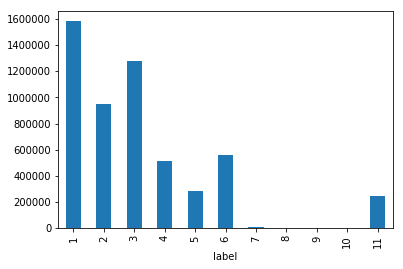

In [6]:
# count target plot
count_data.plot('bar');

**Preprocessing data**

Reducing data by slicing && evaluating slicing koefficients

In [7]:
# stepped data
dff = df.copy()

In [8]:
# data frame for each lable
data_labled = [dff[(dff['label'] == i+1)] for i in range(11)]

# shape for each lable
data_proportion = [data.shape[0] for data in data_labled]

print('data proportion:', data_proportion)

data proportion: [1585401, 948061, 1276632, 512807, 286144, 560978, 9183, 3559, 1971, 338, 242018]


In [9]:
# koefficient for each lable

koef_proportion = [ max(data_proportion) / data for data in data_proportion]

koef_proportion_for_slice = [ round(300 / koef)  for koef in koef_proportion]

print('data proportion koefficient with 0:', koef_proportion_for_slice )

# null less
koef_proportion_for_not_null = []
for koef in koef_proportion_for_slice:
    if koef < 3:
        koef_proportion_for_not_null.append(1)
    else: koef_proportion_for_not_null.append(koef)
print('data proportion koefficient:       ', koef_proportion_for_not_null )

data proportion koefficient with 0: [300, 179, 242, 97, 54, 106, 2, 1, 0, 0, 46]
data proportion koefficient:        [300, 179, 242, 97, 54, 106, 1, 1, 1, 1, 46]


In [10]:
# slicing dataframes
data_reduced = [data.iloc[::koef] for data, koef in zip(data_labled, koef_proportion_for_not_null)]

print('Result size of dataframes: ', [data.shape[0] for data in data_reduced])

Result size of dataframes:  [5285, 5297, 5276, 5287, 5299, 5293, 9183, 3559, 1971, 338, 5262]


In [11]:
# Concatanate for result dataframe
dff = pd.concat(data_reduced, ignore_index=True)

print('Old size dataframe:    ', df.shape[0])
print('Result size dataframe: ', dff.shape[0])

Old size dataframe:     5427092
Result size dataframe:  52050


In [12]:
# Data info
dff.describe()

,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,jerk,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
count,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,...,5.205000e+04,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,52050.000000,5.205000e+04,52050.000000,5.205000e+04
mean,39.162061,105.360098,3614.997042,5.434428,97.583593,33.720096,250.495239,28.620029,-0.122557,0.109580,...,6.999323e+03,28.584067,-0.005662,0.048885,180.873419,5.577091,101.490048,1.328840e+04,0.807469,1.533214e+07
std,5.226520,50.653835,9483.321856,2.947779,48.960062,1180.600447,1910.587670,63.621533,2.516813,2.574105,...,1.419443e+05,63.743996,0.700191,0.678724,65.443661,35.562670,782.505464,9.289653e+04,0.584961,4.150329e+08
min,18.250674,-179.969593,-22900.300000,1.000000,10.000000,0.000000,0.000000,0.000000,-453.194189,-75.251133,...,0.000000e+00,0.000000,-151.064730,-2.794712,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,39.861773,116.197820,36.000000,3.000000,65.000000,1.000000,2.062246,1.016770,-0.159457,-0.073689,...,2.045244e+01,0.998987,-0.035939,-0.004909,179.962519,0.004982,0.000000,0.000000e+00,0.156618,0.000000e+00
50%,39.975267,116.328467,140.000000,5.000000,112.000000,2.000000,9.628436,4.938695,0.000000,0.000000,...,9.447962e+01,4.903840,0.000000,0.000000,180.000000,0.026700,6.000000,2.050237e+01,0.929087,4.341399e+02
75%,40.000263,116.419472,298.600000,7.000000,128.000000,4.000000,29.208317,17.907233,0.129017,0.111005,...,3.069185e+02,17.885076,0.034463,0.006962,180.029990,0.189125,19.600000,1.955583e+02,1.408881,4.045996e+03
max,58.765492,179.996942,51961.900000,11.000000,179.000000,83228.000000,390429.063488,453.194189,61.654042,453.194189,...,8.396369e+06,1047.999944,8.586678,100.709820,359.999945,359.999945,39229.000000,2.976478e+06,1.570784,2.181559e+10


In [13]:
# target count
count_data = dff['label'].groupby(dff['label']).count()
print('type: ', count_data)

type:  label
1     5285
2     5297
3     5276
4     5287
5     5299
6     5293
7     9183
8     3559
9     1971
10     338
11    5262
Name: label, dtype: int64


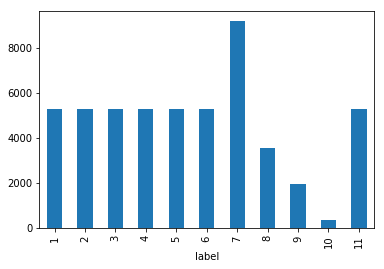

In [14]:
# count target plot
count_data.plot('bar');

**Data input && Splitting data**

In [17]:
# get column titles except the target column
features = dff.columns.tolist()
features.remove('label')
features.remove('time')
print(features)

['lat', 'lon', 'alt', 'user', 'delta_time', 'distance', 'speed', 'acceleration', 'jerk', 'bearing', 'bearing_rate', 'elevation_change', 'elevation_speed', 'elevation_angle', 'elevation_distance', 'delta_time_10', 'distance_10', 'speed_10', 'acceleration_10', 'jerk_10', 'bearing_10', 'bearing_rate_10', 'elevation_change_10', 'elevation_speed_10', 'elevation_angle_10', 'elevation_distance_10']


Get data set features and labels

In [56]:
# Features
X=dff[features].values
# labels
y=dff['label'].values

In [19]:
# split data to train data set and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [20]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Model Classificator**

**KNN**

In [21]:
t_start = time.clock()

# store scores of KNN model by K
scores_knn = []

# loop k from 1 to 9, and get cross validation score of each K value
for k in range(1,9):
    knn=KNeighborsClassifier(k, algorithm='kd_tree', metric='manhattan', weights='uniform')
    score_val=cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    score_mean=score_val.mean()
    print(f'neibors: {k} score: {score_mean:.3f}')
    scores_knn.append(score_mean)
    
# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores_knn)+1
print('\nneibor:', best_k)
# generate KNN model
knn=KNeighborsClassifier(best_k, algorithm='kd_tree', metric='manhattan', weights='uniform')
# fit with train data set
knn.fit(X_train, y_train)
# get Modes presicion rate using test set
#print(f'prediction precision rate: {knn.score(X_test,y_test):.5f}')

# Scores for KNN
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)
y_pred = knn.predict(X_test)

t_end = time.clock()
t_diff = t_end - t_start

print('\n Train scores: \n')
print(f"KNN:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')

neibors: 1 score: 0.720
neibors: 2 score: 0.710
neibors: 3 score: 0.731
neibors: 4 score: 0.735
neibors: 5 score: 0.739
neibors: 6 score: 0.739
neibors: 7 score: 0.740
neibors: 8 score: 0.738

neibor: 7

 Train scores: 

KNN:  1547.01 s. --->>> Score on training / test set: 0.80114 / 0.74802 

accuracy_score = 0.74802
precision_score = 0.73848
recall_score = 0.73939
f1_score = 0.73754 



**KNN & LMNN metric**

In [19]:
# LMNN metric
#https://pylmnn.readthedocs.io/en/stable/api.html#module-pylmnn.lmnn
t_start = time.clock()

scores=[]
# loop k from 1 to 9, and get cross validation score of each K value
k_test, n_components, max_iter = 1, X.shape[1], 10

for k in range(1,9):
    start_time = timeit.default_timer()
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k_test, algorithm='kd_tree', metric='chebyshev', weights='uniform')
    knn.fit(lmnn.transform(X_train), y_train)
    score_val=cross_val_score(knn,lmnn.transform(X_train),y_train,scoring='accuracy',cv=5)
    score_mean=score_val.mean()
    scores.append(score_mean)
    
    end_time = timeit.default_timer() - start_time
    
    print(f'neibors: {k}  ->  score: {score_mean:.5f}  <-  time: {end_time:.0f} s')

# KNN model 

# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores)+1
print('\nneibor:',best_k)
# Instantiate the metric learner
lmnn = LMNN(n_neighbors=int(best_k), max_iter=max_iter, n_components=n_components)
# Train the metric learner
lmnn.fit(X_train, y_train)
# generate KNN model
knn=KNeighborsClassifier(n_neighbors=best_k)
# fit with train data set
knn.fit(lmnn.transform(X_train), y_train)

t_end = time.clock()
t_diff = t_end - t_start

# get Modes presicion rate using test set
print(f'prediction precision rate: {knn.score(lmnn.transform(X_test),y_test):.5f}')

neibors: 1  ->  score: 0.61846  <-  time: 351 s
neibors: 2  ->  score: 0.61849  <-  time: 1121 s
neibors: 3  ->  score: 0.61846  <-  time: 348 s
neibors: 4  ->  score: 0.61854  <-  time: 1155 s
neibors: 5  ->  score: 0.61844  <-  time: 387 s
neibors: 6  ->  score: 0.61859  <-  time: 875 s
neibors: 7  ->  score: 0.62064  <-  time: 1189 s
neibors: 8  ->  score: 0.62049  <-  time: 2998 s

neibor: 7
prediction precision rate: 0.66756
Wall time: 2h 39min 14s


In [22]:
# LMNN metric
#https://pylmnn.readthedocs.io/en/stable/api.html#module-pylmnn.lmnn
t_start = time.clock()

scores=[]
# loop k from 1 to 9, and get cross validation score of each K value
k_test, n_components, max_iter = 1, X.shape[1], 10

for k in range(6,9):
    start_time = timeit.default_timer()
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k_test, algorithm='kd_tree', metric='chebyshev', weights='uniform')
    knn.fit(lmnn.transform(X_train), y_train)
    score_val=cross_val_score(knn,lmnn.transform(X_train),y_train,scoring='accuracy',cv=5)
    score_mean=score_val.mean()
    scores.append(score_mean)
    
    end_time = timeit.default_timer() - start_time
    
    print(f'neibors: {k}  ->  score: {score_mean:.5f}  <-  time: {end_time:.0f} s')

# KNN model 

# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores)+1
print('\nneibor:', best_k)
# Instantiate the metric learner
lmnn = LMNN(n_neighbors=int(best_k), max_iter=max_iter, n_components=n_components)
# Train the metric learner
lmnn.fit(X_train, y_train)
# generate KNN model
knn=KNeighborsClassifier(n_neighbors=best_k)
# fit with train data set
knn.fit(lmnn.transform(X_train), y_train)

# get Modes presicion rate using test set
print(f'prediction precision rate: {knn.score(lmnn.transform(X_test),y_test):.5f}')

# Scores for KNN & LMNN
train_score = knn.score(lmnn.transform(X_train), y_train)
test_score = knn.score(lmnn.transform(X_test), y_test)
#y_pred = knn.predict(lmnn.transform(X_test), y_test)

t_end = time.clock()
t_diff = t_end - t_start

print('\n Train scores: \n')
print(f"KNN & LMNN:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")

neibors: 6  ->  score: 0.67234  <-  time: 807 s
neibors: 7  ->  score: 0.66634  <-  time: 1067 s
neibors: 8  ->  score: 0.67134  <-  time: 1255 s

neibor: 1
prediction precision rate: 0.70322

 Train scores: 

KNN & LMNN:  4258.45 s. --->>> Score on training / test set: 1.00000 / 0.70322 



**SVC**

In [23]:
# SVC model
t_start = time.clock()

clf = SVC(gamma=0.1, C=1)
clf.fit(X_train, y_train)
print(f'prediction precision rate: {clf.score(X_test, y_test):.5f} \n')

# Scores for SVC
y_pred = clf.predict(X_test)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

t_end = time.clock()
t_diff = t_end - t_start

print(f"SVC:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))

prediction precision rate: 0.61269 

SVC:  597.48 s. --->>> Score on training / test set: 0.62448 / 0.61269 

accuracy_score = 0.61269
precision_score = 0.55002
recall_score = 0.56410
f1_score = 0.54266 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# SVC model GridSearchSV
t_start = time.clock()

gamma_aray = np.linspace(0.05, 0.55, 10).tolist()

parameters_svc = {'gamma':gamma_aray, 'C':[1,5]}

svc = SVC()
clf = GridSearchCV(svc, parameters_svc, cv=5)
clf.fit(X_train, y_train);

print('\nevalueted paremetrs SVC: ', clf.best_params_)
#print(f'prediction precision rate: {clf.score(X_test,y_test):.5f} \n')

# Scores for SVC
y_pred = clf.predict(X_test)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

t_end = time.clock()
t_diff = t_end - t_start

print(f"SVC:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))

**Random Forest**

In [41]:
# Random Forest model
t_start = time.clock()

rf_classifier = RandomForestClassifier(n_estimators = 3000)
rf_classifier.fit(X_train, y_train)
#print(f'prediction precision rate: {rf_classifier.score(X_test, y_test):.5f} \n')

# Scores for Random Forest
y_pred = rf_classifier.predict(X_test)
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)

t_end = time.clock()
t_diff = t_end - t_start

print(f"Random Forest:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))

Random Forest:  1259.48 s. --->>> Score on training / test set: 1.00000 / 0.86498 

accuracy_score = 0.86498
precision_score = 0.87885
recall_score = 0.87952
f1_score = 0.87876 



Feature importances

In [44]:
list(zip(features, rf_classifier.feature_importances_))

[('lat', 0.13041279069937844),
 ('lon', 0.13543097805929388),
 ('alt', 0.05470934092085809),
 ('user', 0.09550518207795436),
 ('delta_time', 0.026639626847587992),
 ('distance', 0.045693357061819984),
 ('speed', 0.07017865750408638),
 ('acceleration', 0.013386611978816437),
 ('jerk', 0.013280382979764454),
 ('bearing', 0.01992360829263237),
 ('bearing_rate', 0.015836295152931768),
 ('elevation_change', 0.00502957097848635),
 ('elevation_speed', 0.010930865965419917),
 ('elevation_angle', 0.025381429528170928),
 ('elevation_distance', 0.009218820359235118),
 ('delta_time_10', 0.03632433298624896),
 ('distance_10', 0.06549692694721049),
 ('speed_10', 0.06484902767052245),
 ('acceleration_10', 0.018925539896879725),
 ('jerk_10', 0.013725298122260523),
 ('bearing_10', 0.023208422817493645),
 ('bearing_rate_10', 0.030503415524433683),
 ('elevation_change_10', 0.010433823384356418),
 ('elevation_speed_10', 0.016045018413111678),
 ('elevation_angle_10', 0.03413763401109426),
 ('elevation_dist

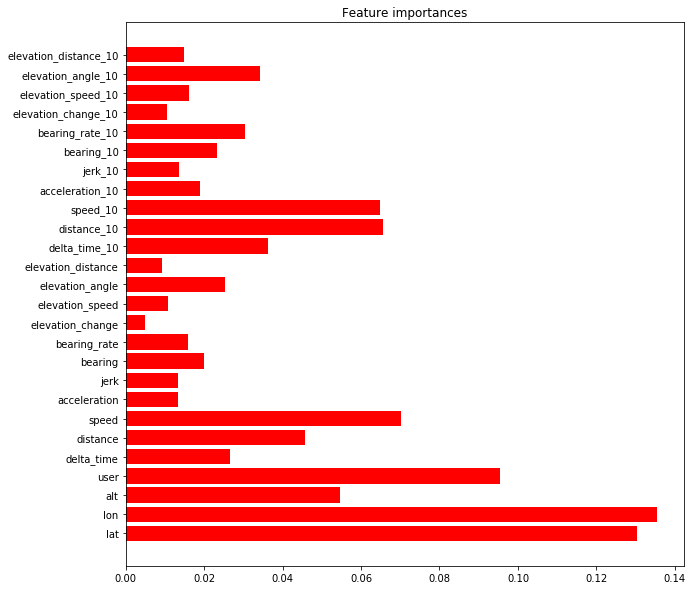

In [45]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(features, rf_classifier.feature_importances_,
       color="r", align="center")
plt.show()

**CatBoost**

In [46]:
# # Scalling data MIN/MAX
# scaler = MinMaxScaler()
# scaler.fit(X)
# X=scaler.transform(X)

In [62]:
# Feature Scaling Normalized

sc = StandardScaler()
X = sc.fit_transform(X)

In [63]:
# split data to train data set and test data set

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.2, random_state=1)

In [64]:
#Creating Pool of train and test
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val) 

#Categorical features declaration
cat_features = list(range(0, X_train.shape[1]))
print('cat features:', cat_features)

cat features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [65]:
# Model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.3,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    early_stopping_rounds=20)

In [66]:
#Fitting
model.fit(train_pool,
          plot=True,
          eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6061479	test: 0.5975024	best: 0.5975024 (0)	total: 6.62s	remaining: 1h 50m 9s
1:	learn: 0.6614553	test: 0.6559798	best: 0.6559798 (1)	total: 13s	remaining: 1h 48m 8s
2:	learn: 0.6914745	test: 0.6865994	best: 0.6865994 (2)	total: 19.6s	remaining: 1h 48m 27s
3:	learn: 0.7147695	test: 0.7054515	best: 0.7054515 (3)	total: 26.4s	remaining: 1h 49m 35s
4:	learn: 0.7293468	test: 0.7221422	best: 0.7221422 (4)	total: 32.9s	remaining: 1h 49m 6s
5:	learn: 0.7491835	test: 0.7436359	best: 0.7436359 (5)	total: 39.5s	remaining: 1h 49m 11s
6:	learn: 0.7554755	test: 0.7497598	best: 0.7497598 (6)	total: 46s	remaining: 1h 48m 47s
7:	learn: 0.7594140	test: 0.7539625	best: 0.7539625 (7)	total: 52.5s	remaining: 1h 48m 26s
8:	learn: 0.7675793	test: 0.7618876	best: 0.7618876 (8)	total: 59.1s	remaining: 1h 48m 27s
9:	learn: 0.7772094	test: 0.7708934	best: 0.7708934 (9)	total: 1m 5s	remaining: 1h 48m 23s
10:	learn: 0.7841499	test: 0.7796590	best: 0.7796590 (10)	total: 1m 11s	remaining: 1h 47m 48s
11:

89:	learn: 0.8859750	test: 0.8638329	best: 0.8639529 (86)	total: 12m 15s	remaining: 2h 3m 55s
90:	learn: 0.8866234	test: 0.8633525	best: 0.8639529 (86)	total: 12m 25s	remaining: 2h 4m 6s
91:	learn: 0.8868396	test: 0.8640730	best: 0.8640730 (91)	total: 12m 35s	remaining: 2h 4m 11s
92:	learn: 0.8876081	test: 0.8649135	best: 0.8649135 (92)	total: 12m 45s	remaining: 2h 4m 22s
93:	learn: 0.8879683	test: 0.8645533	best: 0.8649135 (92)	total: 12m 51s	remaining: 2h 4m
94:	learn: 0.8882085	test: 0.8643132	best: 0.8649135 (92)	total: 12m 59s	remaining: 2h 3m 46s
95:	learn: 0.8889049	test: 0.8637128	best: 0.8649135 (92)	total: 13m 6s	remaining: 2h 3m 27s
96:	learn: 0.8889769	test: 0.8639529	best: 0.8649135 (92)	total: 13m 13s	remaining: 2h 3m 11s
97:	learn: 0.8898175	test: 0.8649135	best: 0.8649135 (92)	total: 13m 21s	remaining: 2h 2m 57s
98:	learn: 0.8902017	test: 0.8655139	best: 0.8655139 (98)	total: 13m 29s	remaining: 2h 2m 46s
99:	learn: 0.8908742	test: 0.8657541	best: 0.8657541 (99)	total: 1

175:	learn: 0.9178434	test: 0.8770413	best: 0.8771614 (174)	total: 23m 45s	remaining: 1h 51m 15s
176:	learn: 0.9179875	test: 0.8772815	best: 0.8772815 (176)	total: 23m 53s	remaining: 1h 51m 5s
177:	learn: 0.9182277	test: 0.8770413	best: 0.8772815 (176)	total: 24m 1s	remaining: 1h 50m 55s
178:	learn: 0.9183958	test: 0.8772815	best: 0.8772815 (176)	total: 24m 8s	remaining: 1h 50m 44s
179:	learn: 0.9186599	test: 0.8777618	best: 0.8777618 (179)	total: 24m 17s	remaining: 1h 50m 38s
180:	learn: 0.9191402	test: 0.8778818	best: 0.8778818 (180)	total: 24m 25s	remaining: 1h 50m 32s
181:	learn: 0.9194524	test: 0.8782421	best: 0.8782421 (181)	total: 24m 32s	remaining: 1h 50m 20s
182:	learn: 0.9195965	test: 0.8778818	best: 0.8782421 (181)	total: 24m 40s	remaining: 1h 50m 10s
183:	learn: 0.9197406	test: 0.8778818	best: 0.8782421 (181)	total: 24m 47s	remaining: 1h 49m 58s
184:	learn: 0.9199328	test: 0.8782421	best: 0.8782421 (181)	total: 24m 54s	remaining: 1h 49m 45s
185:	learn: 0.9201969	test: 0.877

260:	learn: 0.9323247	test: 0.8790826	best: 0.8807637 (254)	total: 34m 40s	remaining: 1h 38m 9s
261:	learn: 0.9328290	test: 0.8799232	best: 0.8807637 (254)	total: 34m 48s	remaining: 1h 38m 2s
262:	learn: 0.9331892	test: 0.8799232	best: 0.8807637 (254)	total: 34m 57s	remaining: 1h 37m 57s
263:	learn: 0.9333333	test: 0.8802834	best: 0.8807637 (254)	total: 35m 6s	remaining: 1h 37m 51s
264:	learn: 0.9334294	test: 0.8798031	best: 0.8807637 (254)	total: 35m 14s	remaining: 1h 37m 45s
265:	learn: 0.9333814	test: 0.8796830	best: 0.8807637 (254)	total: 35m 26s	remaining: 1h 37m 46s
266:	learn: 0.9335014	test: 0.8799232	best: 0.8807637 (254)	total: 35m 35s	remaining: 1h 37m 41s
267:	learn: 0.9341739	test: 0.8798031	best: 0.8807637 (254)	total: 35m 44s	remaining: 1h 37m 36s
268:	learn: 0.9341258	test: 0.8799232	best: 0.8807637 (254)	total: 35m 53s	remaining: 1h 37m 32s
269:	learn: 0.9346542	test: 0.8804035	best: 0.8807637 (254)	total: 36m 2s	remaining: 1h 37m 26s
270:	learn: 0.9351105	test: 0.8806

345:	learn: 0.9469741	test: 0.8849664	best: 0.8850865 (333)	total: 47m 19s	remaining: 1h 29m 28s
346:	learn: 0.9471182	test: 0.8849664	best: 0.8850865 (333)	total: 47m 28s	remaining: 1h 29m 20s
347:	learn: 0.9473583	test: 0.8853266	best: 0.8853266 (347)	total: 47m 37s	remaining: 1h 29m 13s
348:	learn: 0.9475264	test: 0.8847262	best: 0.8853266 (347)	total: 47m 46s	remaining: 1h 29m 6s
349:	learn: 0.9475264	test: 0.8852065	best: 0.8853266 (347)	total: 47m 54s	remaining: 1h 28m 58s
350:	learn: 0.9476225	test: 0.8849664	best: 0.8853266 (347)	total: 48m 3s	remaining: 1h 28m 50s
351:	learn: 0.9478866	test: 0.8854467	best: 0.8854467 (351)	total: 48m 12s	remaining: 1h 28m 45s
352:	learn: 0.9481028	test: 0.8855668	best: 0.8855668 (352)	total: 48m 22s	remaining: 1h 28m 39s
353:	learn: 0.9480307	test: 0.8854467	best: 0.8855668 (352)	total: 48m 31s	remaining: 1h 28m 33s
354:	learn: 0.9486551	test: 0.8855668	best: 0.8855668 (352)	total: 48m 40s	remaining: 1h 28m 26s
355:	learn: 0.9486311	test: 0.88

Learning curves


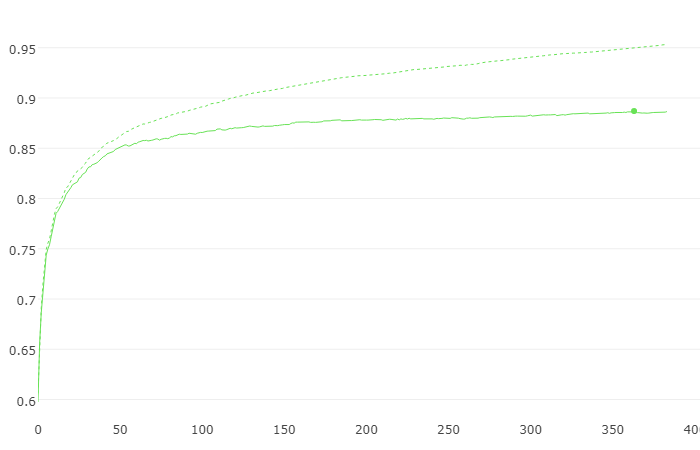

In [111]:
from IPython.display import Image
print('Learning curves')
Image(filename = "newplot.png", width=700, height=500)

In [102]:
# Predictions
y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"CatBoost: \n\nScore on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')

CatBoost: 

Score on training / test set: 0.94938 / 0.88232 

accuracy_score = 0.88232
precision_score = 0.89451
recall_score = 0.89418
f1_score = 0.89398 



**Feature importance**

In [70]:
list(zip(features, model.get_feature_importance(prettified=False)))

[('lat', 17.06217352890362),
 ('lon', 22.212997634849128),
 ('alt', 5.7491537562111095),
 ('user', 17.060192436196758),
 ('delta_time', 4.782742043757874),
 ('distance', 1.0371203932466282),
 ('speed', 6.078304974019842),
 ('acceleration', 0.4915158400018018),
 ('jerk', 0.41143695685199344),
 ('bearing', 0.9348330316014731),
 ('bearing_rate', 0.32209672825700403),
 ('elevation_change', 0.13153523432258288),
 ('elevation_speed', 0.25761005735448733),
 ('elevation_angle', 0.5948161939688841),
 ('elevation_distance', 0.29619395716183156),
 ('delta_time_10', 3.8954480722918152),
 ('distance_10', 5.623516014329308),
 ('speed_10', 5.174323484392695),
 ('acceleration_10', 1.7311597140110053),
 ('jerk_10', 0.4594700819147375),
 ('bearing_10', 0.9683589546559531),
 ('bearing_rate_10', 1.0341368384498582),
 ('elevation_change_10', 0.44592036818669506),
 ('elevation_speed_10', 0.4545910709711872),
 ('elevation_angle_10', 2.272032037852885),
 ('elevation_distance_10', 0.5183205962388648)]

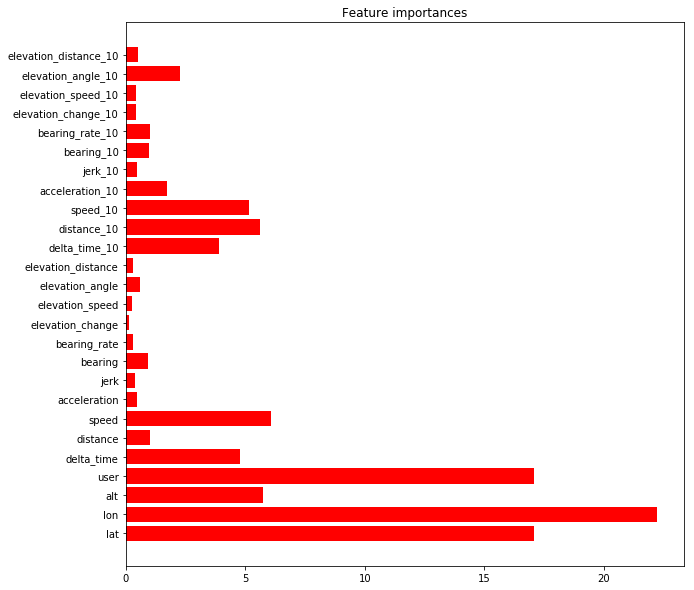

In [71]:
# Plot the feature importances of the boost
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(features, model.get_feature_importance(prettified=False),
       color="r", align="center")
plt.show()

**CatBoost && CrossValidation**

In [79]:
# from catboost import cv

# params = {}
# params['loss_function'] = 'MultiClass'
# params['iterations'] = 50
# #params['custom_loss'] = 'AUC'
# params['random_seed'] = 1
# params['learning_rate'] = 0.4
# params['early_stopping_rounds'] = 5

# cv_data = cv(
#     params = params,
#     pool = Pool(X, label=y),
#     fold_count=5,
#     shuffle=False,
#     partition_random_seed=0,
#     plot=True,
#     stratified=True,
#     verbose=False)

#cv_data.head()
# best_value = np.min(cv_data['test-MultiClass-mean'])
# best_iter = np.argmin(cv_data['test-MultiClass-mean'])

# print('Best validation MultiClass score, stratified: {:.4f}±{:.4f} on step {}'.format(
#     best_value,
#     cv_data['test-MultiClass-std'][best_iter],
#     best_iter))

**Confusion matrix**

In [105]:
#Confusion matrix
#https://habr.com/ru/company/ods/blog/328372/
#http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[169  16  19   4   4   1   0   2   0   0   5]
 [ 10 203   3   5   1   0   0   0   0   0   8]
 [ 13  11 137   5   6   2   0   0   0   0  12]
 [  5   2   9 171   5   0   0   1   0   0  11]
 [  4   3   6   1 205   0   0   0   1   0   3]
 [  2   0   2   2   3 212   1   0   0   0   2]
 [  0   0   0   0   0   0 341   0   0   0   0]
 [  0   0   0   0   0   0   0 137   0   0   0]
 [  1   0   0   0   0   0   0   0  82   0   0]
 [  0   0   0   0   0   0   0   0   0  12   0]
 [ 11  12  25   5   0   1   0   0   0   0 168]]


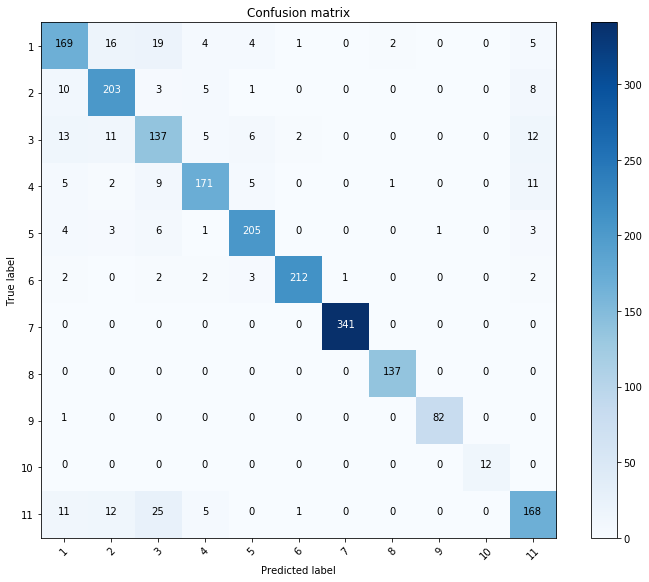

In [93]:
#plot
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm, classes=list(count_data.index),
                      title='Confusion matrix')
plt.show()

**Report**

In [104]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.79      0.77      0.78       220
           2       0.82      0.88      0.85       230
           3       0.68      0.74      0.71       186
           4       0.89      0.84      0.86       204
           5       0.92      0.92      0.92       223
           6       0.98      0.95      0.96       224
           7       1.00      1.00      1.00       341
           8       0.98      1.00      0.99       137
           9       0.99      0.99      0.99        83
          10       1.00      1.00      1.00        12
          11       0.80      0.76      0.78       222

   micro avg       0.88      0.88      0.88      2082
   macro avg       0.89      0.89      0.89      2082
weighted avg       0.88      0.88      0.88      2082



**LightGBM BOOST**

Feature Scaling Normalized

In [112]:
#links
#https://lightgbm.readthedocs.io/en/latest/Python-API.html
#https://lightgbm.readthedocs.io/en/latest/Parameters.html#num_class

# Features
X=dff[features].values
# labels
y=dff['label'].values

#Scalling
sc = StandardScaler()
X = sc.fit_transform(X)

In [113]:
# split data to train data set and test data set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.2, random_state=1)

LGBM Model

In [175]:
# classifier = lgb.LGBMClassifier(boosting_type='gbdt',
#                                 learning_rate=0.1,
#                                 max_depth=-1,
#                                 n_estimators=1000,
#                                 n_jobs=-1,
#                                 num_leaves=60,
#                                 random_state=1,
#                                 bagging_fraction=0.9,
#                                 feature_fraction=0.9,
#                                 subsample_freq=0,
#                                 bagging_freq=5,
#                                 bagging_seed=2018,
#                                 verbosity=-1)
classifier = lgb.LGBMClassifier(n_estimators=2500,learning_rate=0.01)

classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
               early_stopping_rounds=10, categorical_feature='auto')

[1]	valid_0's multi_logloss: 2.23398	valid_1's multi_logloss: 2.24184
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 2.20025	valid_1's multi_logloss: 2.20862
[3]	valid_0's multi_logloss: 2.16874	valid_1's multi_logloss: 2.17741
[4]	valid_0's multi_logloss: 2.13885	valid_1's multi_logloss: 2.14781
[5]	valid_0's multi_logloss: 2.1104	valid_1's multi_logloss: 2.11956
[6]	valid_0's multi_logloss: 2.08324	valid_1's multi_logloss: 2.09275
[7]	valid_0's multi_logloss: 2.05718	valid_1's multi_logloss: 2.06688
[8]	valid_0's multi_logloss: 2.03218	valid_1's multi_logloss: 2.04213
[9]	valid_0's multi_logloss: 2.00803	valid_1's multi_logloss: 2.01811
[10]	valid_0's multi_logloss: 1.9847	valid_1's multi_logloss: 1.99497
[11]	valid_0's multi_logloss: 1.96204	valid_1's multi_logloss: 1.97257
[12]	valid_0's multi_logloss: 1.9402	valid_1's multi_logloss: 1.95078
[13]	valid_0's multi_logloss: 1.91899	valid_1's multi_logloss: 1.92983
[14]	valid_0's multi_loglos

[116]	valid_0's multi_logloss: 0.949901	valid_1's multi_logloss: 0.972494
[117]	valid_0's multi_logloss: 0.945329	valid_1's multi_logloss: 0.968063
[118]	valid_0's multi_logloss: 0.940815	valid_1's multi_logloss: 0.96365
[119]	valid_0's multi_logloss: 0.936349	valid_1's multi_logloss: 0.959248
[120]	valid_0's multi_logloss: 0.931914	valid_1's multi_logloss: 0.954922
[121]	valid_0's multi_logloss: 0.927639	valid_1's multi_logloss: 0.950822
[122]	valid_0's multi_logloss: 0.92331	valid_1's multi_logloss: 0.946635
[123]	valid_0's multi_logloss: 0.919066	valid_1's multi_logloss: 0.9425
[124]	valid_0's multi_logloss: 0.914822	valid_1's multi_logloss: 0.938373
[125]	valid_0's multi_logloss: 0.910634	valid_1's multi_logloss: 0.934325
[126]	valid_0's multi_logloss: 0.906517	valid_1's multi_logloss: 0.930328
[127]	valid_0's multi_logloss: 0.902404	valid_1's multi_logloss: 0.926371
[128]	valid_0's multi_logloss: 0.898364	valid_1's multi_logloss: 0.92254
[129]	valid_0's multi_logloss: 0.894321	val

[228]	valid_0's multi_logloss: 0.625587	valid_1's multi_logloss: 0.656969
[229]	valid_0's multi_logloss: 0.623784	valid_1's multi_logloss: 0.655237
[230]	valid_0's multi_logloss: 0.622029	valid_1's multi_logloss: 0.653528
[231]	valid_0's multi_logloss: 0.620286	valid_1's multi_logloss: 0.65185
[232]	valid_0's multi_logloss: 0.618518	valid_1's multi_logloss: 0.65016
[233]	valid_0's multi_logloss: 0.616785	valid_1's multi_logloss: 0.648516
[234]	valid_0's multi_logloss: 0.615071	valid_1's multi_logloss: 0.64687
[235]	valid_0's multi_logloss: 0.613413	valid_1's multi_logloss: 0.645375
[236]	valid_0's multi_logloss: 0.611661	valid_1's multi_logloss: 0.643684
[237]	valid_0's multi_logloss: 0.610003	valid_1's multi_logloss: 0.642073
[238]	valid_0's multi_logloss: 0.608339	valid_1's multi_logloss: 0.640515
[239]	valid_0's multi_logloss: 0.60672	valid_1's multi_logloss: 0.638974
[240]	valid_0's multi_logloss: 0.605075	valid_1's multi_logloss: 0.63741
[241]	valid_0's multi_logloss: 0.603453	val

[340]	valid_0's multi_logloss: 0.48288	valid_1's multi_logloss: 0.524107
[341]	valid_0's multi_logloss: 0.48201	valid_1's multi_logloss: 0.523326
[342]	valid_0's multi_logloss: 0.481165	valid_1's multi_logloss: 0.522568
[343]	valid_0's multi_logloss: 0.480261	valid_1's multi_logloss: 0.521718
[344]	valid_0's multi_logloss: 0.479398	valid_1's multi_logloss: 0.520962
[345]	valid_0's multi_logloss: 0.478537	valid_1's multi_logloss: 0.520208
[346]	valid_0's multi_logloss: 0.477712	valid_1's multi_logloss: 0.519466
[347]	valid_0's multi_logloss: 0.476843	valid_1's multi_logloss: 0.518696
[348]	valid_0's multi_logloss: 0.476011	valid_1's multi_logloss: 0.517972
[349]	valid_0's multi_logloss: 0.475192	valid_1's multi_logloss: 0.517234
[350]	valid_0's multi_logloss: 0.474379	valid_1's multi_logloss: 0.516502
[351]	valid_0's multi_logloss: 0.47357	valid_1's multi_logloss: 0.515769
[352]	valid_0's multi_logloss: 0.4728	valid_1's multi_logloss: 0.515097
[353]	valid_0's multi_logloss: 0.471939	val

[452]	valid_0's multi_logloss: 0.410143	valid_1's multi_logloss: 0.461456
[453]	valid_0's multi_logloss: 0.409671	valid_1's multi_logloss: 0.461036
[454]	valid_0's multi_logloss: 0.409197	valid_1's multi_logloss: 0.460654
[455]	valid_0's multi_logloss: 0.408717	valid_1's multi_logloss: 0.460228
[456]	valid_0's multi_logloss: 0.408266	valid_1's multi_logloss: 0.4599
[457]	valid_0's multi_logloss: 0.407766	valid_1's multi_logloss: 0.45951
[458]	valid_0's multi_logloss: 0.40729	valid_1's multi_logloss: 0.459119
[459]	valid_0's multi_logloss: 0.40684	valid_1's multi_logloss: 0.458788
[460]	valid_0's multi_logloss: 0.406376	valid_1's multi_logloss: 0.458393
[461]	valid_0's multi_logloss: 0.405914	valid_1's multi_logloss: 0.458061
[462]	valid_0's multi_logloss: 0.405444	valid_1's multi_logloss: 0.457683
[463]	valid_0's multi_logloss: 0.404988	valid_1's multi_logloss: 0.457296
[464]	valid_0's multi_logloss: 0.404527	valid_1's multi_logloss: 0.456931
[465]	valid_0's multi_logloss: 0.40406	vali

[564]	valid_0's multi_logloss: 0.365249	valid_1's multi_logloss: 0.429134
[565]	valid_0's multi_logloss: 0.364859	valid_1's multi_logloss: 0.428862
[566]	valid_0's multi_logloss: 0.364503	valid_1's multi_logloss: 0.428589
[567]	valid_0's multi_logloss: 0.364142	valid_1's multi_logloss: 0.428327
[568]	valid_0's multi_logloss: 0.363805	valid_1's multi_logloss: 0.4281
[569]	valid_0's multi_logloss: 0.363478	valid_1's multi_logloss: 0.427888
[570]	valid_0's multi_logloss: 0.363135	valid_1's multi_logloss: 0.427625
[571]	valid_0's multi_logloss: 0.36278	valid_1's multi_logloss: 0.427411
[572]	valid_0's multi_logloss: 0.362469	valid_1's multi_logloss: 0.427231
[573]	valid_0's multi_logloss: 0.362133	valid_1's multi_logloss: 0.427016
[574]	valid_0's multi_logloss: 0.361825	valid_1's multi_logloss: 0.426802
[575]	valid_0's multi_logloss: 0.361492	valid_1's multi_logloss: 0.426589
[576]	valid_0's multi_logloss: 0.361141	valid_1's multi_logloss: 0.426278
[577]	valid_0's multi_logloss: 0.36079	va

[675]	valid_0's multi_logloss: 0.333909	valid_1's multi_logloss: 0.40927
[676]	valid_0's multi_logloss: 0.333656	valid_1's multi_logloss: 0.409106
[677]	valid_0's multi_logloss: 0.333418	valid_1's multi_logloss: 0.408978
[678]	valid_0's multi_logloss: 0.333172	valid_1's multi_logloss: 0.408839
[679]	valid_0's multi_logloss: 0.332945	valid_1's multi_logloss: 0.408728
[680]	valid_0's multi_logloss: 0.332706	valid_1's multi_logloss: 0.408606
[681]	valid_0's multi_logloss: 0.332457	valid_1's multi_logloss: 0.408474
[682]	valid_0's multi_logloss: 0.332242	valid_1's multi_logloss: 0.408373
[683]	valid_0's multi_logloss: 0.332022	valid_1's multi_logloss: 0.40827
[684]	valid_0's multi_logloss: 0.331781	valid_1's multi_logloss: 0.408122
[685]	valid_0's multi_logloss: 0.331545	valid_1's multi_logloss: 0.407978
[686]	valid_0's multi_logloss: 0.33129	valid_1's multi_logloss: 0.407812
[687]	valid_0's multi_logloss: 0.331057	valid_1's multi_logloss: 0.407701
[688]	valid_0's multi_logloss: 0.330831	v

[787]	valid_0's multi_logloss: 0.310006	valid_1's multi_logloss: 0.395785
[788]	valid_0's multi_logloss: 0.309808	valid_1's multi_logloss: 0.39571
[789]	valid_0's multi_logloss: 0.309634	valid_1's multi_logloss: 0.395598
[790]	valid_0's multi_logloss: 0.309451	valid_1's multi_logloss: 0.395493
[791]	valid_0's multi_logloss: 0.309275	valid_1's multi_logloss: 0.39541
[792]	valid_0's multi_logloss: 0.309079	valid_1's multi_logloss: 0.395322
[793]	valid_0's multi_logloss: 0.308892	valid_1's multi_logloss: 0.39522
[794]	valid_0's multi_logloss: 0.308694	valid_1's multi_logloss: 0.395119
[795]	valid_0's multi_logloss: 0.308503	valid_1's multi_logloss: 0.395058
[796]	valid_0's multi_logloss: 0.308326	valid_1's multi_logloss: 0.394959
[797]	valid_0's multi_logloss: 0.308145	valid_1's multi_logloss: 0.394866
[798]	valid_0's multi_logloss: 0.307972	valid_1's multi_logloss: 0.394783
[799]	valid_0's multi_logloss: 0.307788	valid_1's multi_logloss: 0.394688
[800]	valid_0's multi_logloss: 0.307597	v

[899]	valid_0's multi_logloss: 0.290779	valid_1's multi_logloss: 0.386535
[900]	valid_0's multi_logloss: 0.290643	valid_1's multi_logloss: 0.386479
[901]	valid_0's multi_logloss: 0.290478	valid_1's multi_logloss: 0.386415
[902]	valid_0's multi_logloss: 0.290334	valid_1's multi_logloss: 0.386365
[903]	valid_0's multi_logloss: 0.290195	valid_1's multi_logloss: 0.386301
[904]	valid_0's multi_logloss: 0.290042	valid_1's multi_logloss: 0.386223
[905]	valid_0's multi_logloss: 0.289895	valid_1's multi_logloss: 0.386198
[906]	valid_0's multi_logloss: 0.28972	valid_1's multi_logloss: 0.386111
[907]	valid_0's multi_logloss: 0.289564	valid_1's multi_logloss: 0.386054
[908]	valid_0's multi_logloss: 0.289408	valid_1's multi_logloss: 0.385974
[909]	valid_0's multi_logloss: 0.289265	valid_1's multi_logloss: 0.385938
[910]	valid_0's multi_logloss: 0.28911	valid_1's multi_logloss: 0.385888
[911]	valid_0's multi_logloss: 0.28895	valid_1's multi_logloss: 0.385819
[912]	valid_0's multi_logloss: 0.288771	v

[1010]	valid_0's multi_logloss: 0.274529	valid_1's multi_logloss: 0.379274
[1011]	valid_0's multi_logloss: 0.274374	valid_1's multi_logloss: 0.379177
[1012]	valid_0's multi_logloss: 0.274236	valid_1's multi_logloss: 0.379142
[1013]	valid_0's multi_logloss: 0.274107	valid_1's multi_logloss: 0.379105
[1014]	valid_0's multi_logloss: 0.273976	valid_1's multi_logloss: 0.37906
[1015]	valid_0's multi_logloss: 0.273841	valid_1's multi_logloss: 0.379015
[1016]	valid_0's multi_logloss: 0.273708	valid_1's multi_logloss: 0.378946
[1017]	valid_0's multi_logloss: 0.273582	valid_1's multi_logloss: 0.37888
[1018]	valid_0's multi_logloss: 0.273432	valid_1's multi_logloss: 0.378819
[1019]	valid_0's multi_logloss: 0.273292	valid_1's multi_logloss: 0.378782
[1020]	valid_0's multi_logloss: 0.27316	valid_1's multi_logloss: 0.378723
[1021]	valid_0's multi_logloss: 0.273013	valid_1's multi_logloss: 0.378689
[1022]	valid_0's multi_logloss: 0.272884	valid_1's multi_logloss: 0.378616
[1023]	valid_0's multi_loglo

[1120]	valid_0's multi_logloss: 0.260482	valid_1's multi_logloss: 0.373778
[1121]	valid_0's multi_logloss: 0.260386	valid_1's multi_logloss: 0.373779
[1122]	valid_0's multi_logloss: 0.260258	valid_1's multi_logloss: 0.373708
[1123]	valid_0's multi_logloss: 0.260134	valid_1's multi_logloss: 0.373657
[1124]	valid_0's multi_logloss: 0.260025	valid_1's multi_logloss: 0.373596
[1125]	valid_0's multi_logloss: 0.259905	valid_1's multi_logloss: 0.373562
[1126]	valid_0's multi_logloss: 0.2598	valid_1's multi_logloss: 0.373529
[1127]	valid_0's multi_logloss: 0.259681	valid_1's multi_logloss: 0.373492
[1128]	valid_0's multi_logloss: 0.259536	valid_1's multi_logloss: 0.373385
[1129]	valid_0's multi_logloss: 0.2594	valid_1's multi_logloss: 0.373321
[1130]	valid_0's multi_logloss: 0.259279	valid_1's multi_logloss: 0.37329
[1131]	valid_0's multi_logloss: 0.259158	valid_1's multi_logloss: 0.373237
[1132]	valid_0's multi_logloss: 0.259041	valid_1's multi_logloss: 0.373206
[1133]	valid_0's multi_logloss

[1230]	valid_0's multi_logloss: 0.248033	valid_1's multi_logloss: 0.369975
[1231]	valid_0's multi_logloss: 0.247924	valid_1's multi_logloss: 0.36997
[1232]	valid_0's multi_logloss: 0.247799	valid_1's multi_logloss: 0.369927
[1233]	valid_0's multi_logloss: 0.247696	valid_1's multi_logloss: 0.369905
[1234]	valid_0's multi_logloss: 0.247589	valid_1's multi_logloss: 0.369892
[1235]	valid_0's multi_logloss: 0.24748	valid_1's multi_logloss: 0.369844
[1236]	valid_0's multi_logloss: 0.247359	valid_1's multi_logloss: 0.369816
[1237]	valid_0's multi_logloss: 0.247264	valid_1's multi_logloss: 0.369801
[1238]	valid_0's multi_logloss: 0.247171	valid_1's multi_logloss: 0.369788
[1239]	valid_0's multi_logloss: 0.24705	valid_1's multi_logloss: 0.369741
[1240]	valid_0's multi_logloss: 0.246945	valid_1's multi_logloss: 0.369736
[1241]	valid_0's multi_logloss: 0.246842	valid_1's multi_logloss: 0.369688
[1242]	valid_0's multi_logloss: 0.246739	valid_1's multi_logloss: 0.369676
[1243]	valid_0's multi_loglo

[1340]	valid_0's multi_logloss: 0.236593	valid_1's multi_logloss: 0.366786
[1341]	valid_0's multi_logloss: 0.236489	valid_1's multi_logloss: 0.366774
[1342]	valid_0's multi_logloss: 0.236393	valid_1's multi_logloss: 0.366744
[1343]	valid_0's multi_logloss: 0.236293	valid_1's multi_logloss: 0.366714
[1344]	valid_0's multi_logloss: 0.236199	valid_1's multi_logloss: 0.366667
[1345]	valid_0's multi_logloss: 0.23609	valid_1's multi_logloss: 0.36664
[1346]	valid_0's multi_logloss: 0.236002	valid_1's multi_logloss: 0.366615
[1347]	valid_0's multi_logloss: 0.235916	valid_1's multi_logloss: 0.366598
[1348]	valid_0's multi_logloss: 0.235809	valid_1's multi_logloss: 0.366568
[1349]	valid_0's multi_logloss: 0.235724	valid_1's multi_logloss: 0.366563
[1350]	valid_0's multi_logloss: 0.235623	valid_1's multi_logloss: 0.366525
[1351]	valid_0's multi_logloss: 0.235545	valid_1's multi_logloss: 0.366516
[1352]	valid_0's multi_logloss: 0.235449	valid_1's multi_logloss: 0.36649
[1353]	valid_0's multi_loglo

[1451]	valid_0's multi_logloss: 0.226437	valid_1's multi_logloss: 0.364274
[1452]	valid_0's multi_logloss: 0.226344	valid_1's multi_logloss: 0.364234
[1453]	valid_0's multi_logloss: 0.226256	valid_1's multi_logloss: 0.364209
[1454]	valid_0's multi_logloss: 0.226164	valid_1's multi_logloss: 0.364185
[1455]	valid_0's multi_logloss: 0.226069	valid_1's multi_logloss: 0.364174
[1456]	valid_0's multi_logloss: 0.225989	valid_1's multi_logloss: 0.364169
[1457]	valid_0's multi_logloss: 0.225905	valid_1's multi_logloss: 0.364157
[1458]	valid_0's multi_logloss: 0.225812	valid_1's multi_logloss: 0.36411
[1459]	valid_0's multi_logloss: 0.225703	valid_1's multi_logloss: 0.364083
[1460]	valid_0's multi_logloss: 0.225612	valid_1's multi_logloss: 0.364075
[1461]	valid_0's multi_logloss: 0.225517	valid_1's multi_logloss: 0.364041
[1462]	valid_0's multi_logloss: 0.22542	valid_1's multi_logloss: 0.364001
[1463]	valid_0's multi_logloss: 0.225334	valid_1's multi_logloss: 0.363981
[1464]	valid_0's multi_logl

[1561]	valid_0's multi_logloss: 0.216655	valid_1's multi_logloss: 0.361555
[1562]	valid_0's multi_logloss: 0.216579	valid_1's multi_logloss: 0.361536
[1563]	valid_0's multi_logloss: 0.216502	valid_1's multi_logloss: 0.361539
[1564]	valid_0's multi_logloss: 0.216419	valid_1's multi_logloss: 0.361512
[1565]	valid_0's multi_logloss: 0.216344	valid_1's multi_logloss: 0.361494
[1566]	valid_0's multi_logloss: 0.216247	valid_1's multi_logloss: 0.36146
[1567]	valid_0's multi_logloss: 0.21614	valid_1's multi_logloss: 0.361389
[1568]	valid_0's multi_logloss: 0.216063	valid_1's multi_logloss: 0.361394
[1569]	valid_0's multi_logloss: 0.215979	valid_1's multi_logloss: 0.361378
[1570]	valid_0's multi_logloss: 0.215893	valid_1's multi_logloss: 0.361352
[1571]	valid_0's multi_logloss: 0.215809	valid_1's multi_logloss: 0.361313
[1572]	valid_0's multi_logloss: 0.215713	valid_1's multi_logloss: 0.361289
[1573]	valid_0's multi_logloss: 0.215638	valid_1's multi_logloss: 0.361265
[1574]	valid_0's multi_logl

[1672]	valid_0's multi_logloss: 0.207561	valid_1's multi_logloss: 0.359401
[1673]	valid_0's multi_logloss: 0.207481	valid_1's multi_logloss: 0.359378
[1674]	valid_0's multi_logloss: 0.207406	valid_1's multi_logloss: 0.359357
[1675]	valid_0's multi_logloss: 0.207324	valid_1's multi_logloss: 0.359341
[1676]	valid_0's multi_logloss: 0.207253	valid_1's multi_logloss: 0.35933
[1677]	valid_0's multi_logloss: 0.207178	valid_1's multi_logloss: 0.359316
[1678]	valid_0's multi_logloss: 0.207095	valid_1's multi_logloss: 0.359321
[1679]	valid_0's multi_logloss: 0.207014	valid_1's multi_logloss: 0.359328
[1680]	valid_0's multi_logloss: 0.206939	valid_1's multi_logloss: 0.359312
[1681]	valid_0's multi_logloss: 0.206877	valid_1's multi_logloss: 0.359295
[1682]	valid_0's multi_logloss: 0.2068	valid_1's multi_logloss: 0.359285
[1683]	valid_0's multi_logloss: 0.206718	valid_1's multi_logloss: 0.359252
[1684]	valid_0's multi_logloss: 0.206636	valid_1's multi_logloss: 0.359226
[1685]	valid_0's multi_loglo

[1783]	valid_0's multi_logloss: 0.198945	valid_1's multi_logloss: 0.357418
[1784]	valid_0's multi_logloss: 0.198873	valid_1's multi_logloss: 0.357413
[1785]	valid_0's multi_logloss: 0.19879	valid_1's multi_logloss: 0.357358
[1786]	valid_0's multi_logloss: 0.198727	valid_1's multi_logloss: 0.357357
[1787]	valid_0's multi_logloss: 0.198649	valid_1's multi_logloss: 0.357329
[1788]	valid_0's multi_logloss: 0.19859	valid_1's multi_logloss: 0.357296
[1789]	valid_0's multi_logloss: 0.198513	valid_1's multi_logloss: 0.357284
[1790]	valid_0's multi_logloss: 0.198448	valid_1's multi_logloss: 0.357287
[1791]	valid_0's multi_logloss: 0.198372	valid_1's multi_logloss: 0.357269
[1792]	valid_0's multi_logloss: 0.1983	valid_1's multi_logloss: 0.357232
[1793]	valid_0's multi_logloss: 0.198225	valid_1's multi_logloss: 0.357235
[1794]	valid_0's multi_logloss: 0.198152	valid_1's multi_logloss: 0.357232
[1795]	valid_0's multi_logloss: 0.198063	valid_1's multi_logloss: 0.357192
[1796]	valid_0's multi_loglos

[1894]	valid_0's multi_logloss: 0.190752	valid_1's multi_logloss: 0.355443
[1895]	valid_0's multi_logloss: 0.190683	valid_1's multi_logloss: 0.355435
[1896]	valid_0's multi_logloss: 0.190607	valid_1's multi_logloss: 0.355425
[1897]	valid_0's multi_logloss: 0.190529	valid_1's multi_logloss: 0.355392
[1898]	valid_0's multi_logloss: 0.190468	valid_1's multi_logloss: 0.355377
[1899]	valid_0's multi_logloss: 0.190399	valid_1's multi_logloss: 0.355357
[1900]	valid_0's multi_logloss: 0.19032	valid_1's multi_logloss: 0.355357
[1901]	valid_0's multi_logloss: 0.190255	valid_1's multi_logloss: 0.355329
[1902]	valid_0's multi_logloss: 0.190193	valid_1's multi_logloss: 0.355313
[1903]	valid_0's multi_logloss: 0.190127	valid_1's multi_logloss: 0.355331
[1904]	valid_0's multi_logloss: 0.190061	valid_1's multi_logloss: 0.355278
[1905]	valid_0's multi_logloss: 0.190001	valid_1's multi_logloss: 0.35527
[1906]	valid_0's multi_logloss: 0.189934	valid_1's multi_logloss: 0.355249
[1907]	valid_0's multi_logl

[2005]	valid_0's multi_logloss: 0.183132	valid_1's multi_logloss: 0.353725
[2006]	valid_0's multi_logloss: 0.183068	valid_1's multi_logloss: 0.353723
[2007]	valid_0's multi_logloss: 0.183008	valid_1's multi_logloss: 0.35369
[2008]	valid_0's multi_logloss: 0.182945	valid_1's multi_logloss: 0.353664
[2009]	valid_0's multi_logloss: 0.182866	valid_1's multi_logloss: 0.353641
[2010]	valid_0's multi_logloss: 0.182798	valid_1's multi_logloss: 0.353618
[2011]	valid_0's multi_logloss: 0.182721	valid_1's multi_logloss: 0.353592
[2012]	valid_0's multi_logloss: 0.182652	valid_1's multi_logloss: 0.353608
[2013]	valid_0's multi_logloss: 0.182583	valid_1's multi_logloss: 0.353589
[2014]	valid_0's multi_logloss: 0.182506	valid_1's multi_logloss: 0.353561
[2015]	valid_0's multi_logloss: 0.182446	valid_1's multi_logloss: 0.353529
[2016]	valid_0's multi_logloss: 0.182376	valid_1's multi_logloss: 0.35354
[2017]	valid_0's multi_logloss: 0.182309	valid_1's multi_logloss: 0.353536
[2018]	valid_0's multi_logl

[2115]	valid_0's multi_logloss: 0.175853	valid_1's multi_logloss: 0.351716
[2116]	valid_0's multi_logloss: 0.175792	valid_1's multi_logloss: 0.351717
[2117]	valid_0's multi_logloss: 0.175713	valid_1's multi_logloss: 0.351689
[2118]	valid_0's multi_logloss: 0.175648	valid_1's multi_logloss: 0.351684
[2119]	valid_0's multi_logloss: 0.175586	valid_1's multi_logloss: 0.351665
[2120]	valid_0's multi_logloss: 0.175517	valid_1's multi_logloss: 0.351651
[2121]	valid_0's multi_logloss: 0.175448	valid_1's multi_logloss: 0.351628
[2122]	valid_0's multi_logloss: 0.175379	valid_1's multi_logloss: 0.351611
[2123]	valid_0's multi_logloss: 0.175304	valid_1's multi_logloss: 0.351596
[2124]	valid_0's multi_logloss: 0.175231	valid_1's multi_logloss: 0.35158
[2125]	valid_0's multi_logloss: 0.175161	valid_1's multi_logloss: 0.351571
[2126]	valid_0's multi_logloss: 0.175095	valid_1's multi_logloss: 0.35156
[2127]	valid_0's multi_logloss: 0.175016	valid_1's multi_logloss: 0.351548
[2128]	valid_0's multi_logl

[2225]	valid_0's multi_logloss: 0.168866	valid_1's multi_logloss: 0.34989
[2226]	valid_0's multi_logloss: 0.1688	valid_1's multi_logloss: 0.349885
[2227]	valid_0's multi_logloss: 0.168734	valid_1's multi_logloss: 0.349886
[2228]	valid_0's multi_logloss: 0.168671	valid_1's multi_logloss: 0.349848
[2229]	valid_0's multi_logloss: 0.16861	valid_1's multi_logloss: 0.349844
[2230]	valid_0's multi_logloss: 0.168551	valid_1's multi_logloss: 0.349856
[2231]	valid_0's multi_logloss: 0.168502	valid_1's multi_logloss: 0.34984
[2232]	valid_0's multi_logloss: 0.168446	valid_1's multi_logloss: 0.349831
[2233]	valid_0's multi_logloss: 0.168381	valid_1's multi_logloss: 0.349811
[2234]	valid_0's multi_logloss: 0.168321	valid_1's multi_logloss: 0.3498
[2235]	valid_0's multi_logloss: 0.168262	valid_1's multi_logloss: 0.349769
[2236]	valid_0's multi_logloss: 0.168197	valid_1's multi_logloss: 0.349751
[2237]	valid_0's multi_logloss: 0.168127	valid_1's multi_logloss: 0.349721
[2238]	valid_0's multi_logloss: 

[2336]	valid_0's multi_logloss: 0.162341	valid_1's multi_logloss: 0.34861
[2337]	valid_0's multi_logloss: 0.162287	valid_1's multi_logloss: 0.348618
[2338]	valid_0's multi_logloss: 0.162236	valid_1's multi_logloss: 0.348611
[2339]	valid_0's multi_logloss: 0.162175	valid_1's multi_logloss: 0.348603
[2340]	valid_0's multi_logloss: 0.162119	valid_1's multi_logloss: 0.348593
[2341]	valid_0's multi_logloss: 0.162053	valid_1's multi_logloss: 0.348573
[2342]	valid_0's multi_logloss: 0.162001	valid_1's multi_logloss: 0.348592
[2343]	valid_0's multi_logloss: 0.161943	valid_1's multi_logloss: 0.348582
[2344]	valid_0's multi_logloss: 0.161892	valid_1's multi_logloss: 0.348583
[2345]	valid_0's multi_logloss: 0.161844	valid_1's multi_logloss: 0.348578
[2346]	valid_0's multi_logloss: 0.161793	valid_1's multi_logloss: 0.348585
[2347]	valid_0's multi_logloss: 0.161737	valid_1's multi_logloss: 0.348594
[2348]	valid_0's multi_logloss: 0.16168	valid_1's multi_logloss: 0.348588
[2349]	valid_0's multi_logl

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Predict

In [176]:
y_pred = classifier.predict(X_test)
train_score = classifier.score(X_train, y_train)
test_score = classifier.score(X_test, y_test)

print(f"LightGBM: \n\nScore on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')

LightGBM: 

Score on training / test set: 0.95934 / 0.88136 

accuracy_score = 0.88136
precision_score = 0.88805
recall_score = 0.89430
f1_score = 0.89059 



**Confusion matrix**

Confusion matrix, without normalization
[[170  19  15   2   6   1   0   0   0   1   6]
 [ 10 203   3   6   0   0   0   0   0   0   8]
 [ 14   7 142   6   6   3   0   0   0   0   8]
 [  4   1   7 167   8   0   0   1   0   0  16]
 [  6   3   5   3 205   0   0   0   0   0   1]
 [  1   1   2   0   2 214   0   0   0   0   4]
 [  0   0   0   0   0   0 341   0   0   0   0]
 [  0   0   0   0   0   0   0 137   0   0   0]
 [  0   0   0   0   0   0   0   0  83   0   0]
 [  0   0   0   0   0   0   0   0   0  12   0]
 [ 15  11  27   4   1   3   0   0   0   0 161]]


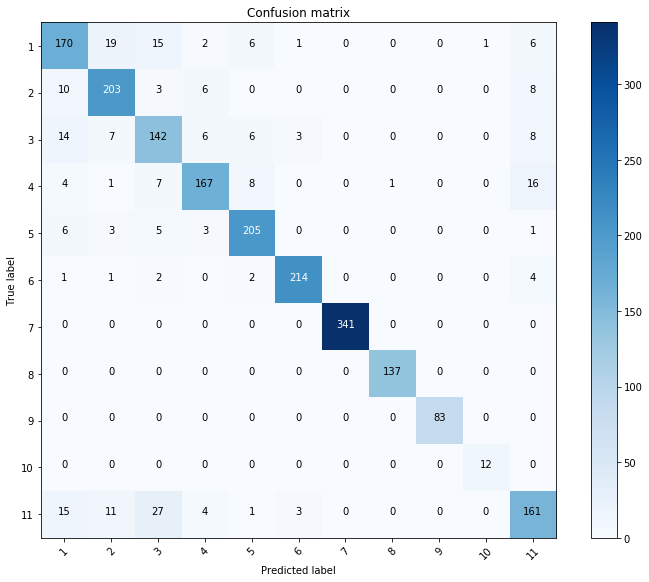

In [178]:
cm_lgb = confusion_matrix(y_test, y_pred)

#plot
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm_lgb, classes=list(count_data.index),
                      title='Confusion matrix')
plt.show()

**Report**

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.77      0.77       220
           2       0.83      0.88      0.85       230
           3       0.71      0.76      0.73       186
           4       0.89      0.82      0.85       204
           5       0.90      0.92      0.91       223
           6       0.97      0.96      0.96       224
           7       1.00      1.00      1.00       341
           8       0.99      1.00      1.00       137
           9       1.00      1.00      1.00        83
          10       0.92      1.00      0.96        12
          11       0.79      0.73      0.76       222

   micro avg       0.88      0.88      0.88      2082
   macro avg       0.89      0.89      0.89      2082
weighted avg       0.88      0.88      0.88      2082

